# Определение возраста покупателей для сетевого супермаркета «Хлеб-Соль»

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста. 

Вашей метрикой качества будет *MAE* — если вы получите *MAE* меньше 7, это будет отличный результат!

## Подготовка

Импортируем необходимые библиотеки, объявим вспомогательные функции, зафиксируем рандомстейт.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def decl_of_num(num: int, titles: tuple[str, str, str]) -> str:
    cases = (2, 0, 1, 1, 1, 2)
    title = titles[2 if (num % 100 > 4 and num % 100 < 20) else cases[min(num % 10, 5)]]
    return f'{num} {title}'

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
RANDOM_STATE = 12345
DATA_PATH = '/datasets/faces/'

### Загрузка и предобработка данных

Считаем CSV-файл с данными и сохраним его в датафрейм `labels_df`.

In [5]:
labels_df = pd.read_csv(DATA_PATH + 'labels.csv')

In [6]:
labels_df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Датафрейм `labels_df`с набором данных с разметкой фотографий содержит следующие признаки:
- `file_name` — имя файла с фотографией;
- `real_age` — возраст, **целевой признак**.

Изучим общую информацию о датафрейме.

In [7]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, всего 7 591 записей. Проверим дубликаты.

In [8]:
labels_df.duplicated(subset='file_name').sum()

0

Дубликатов нет.

### Исследовательский анализ данных

#### Возраст

Посмотрим на числовое описание целевого признака `real_age`.

In [9]:
labels_df['real_age'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Построим диаграмму размаха.

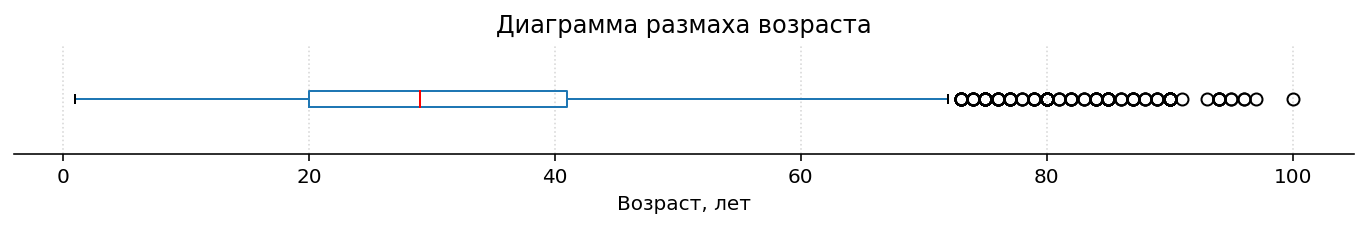

In [10]:
fig, ax = plt.subplots(figsize=(12, 1))

labels_df['real_age'].plot(kind='box', vert=False, ax=ax, medianprops={'color': 'red'})
ax.set_title('Диаграмма размаха возраста')
ax.set_xlabel('Возраст, лет')
ax.set_yticklabels([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(axis='x', alpha=0.5, linestyle=':')

plt.show()

Построим гистограмму распределения признака.

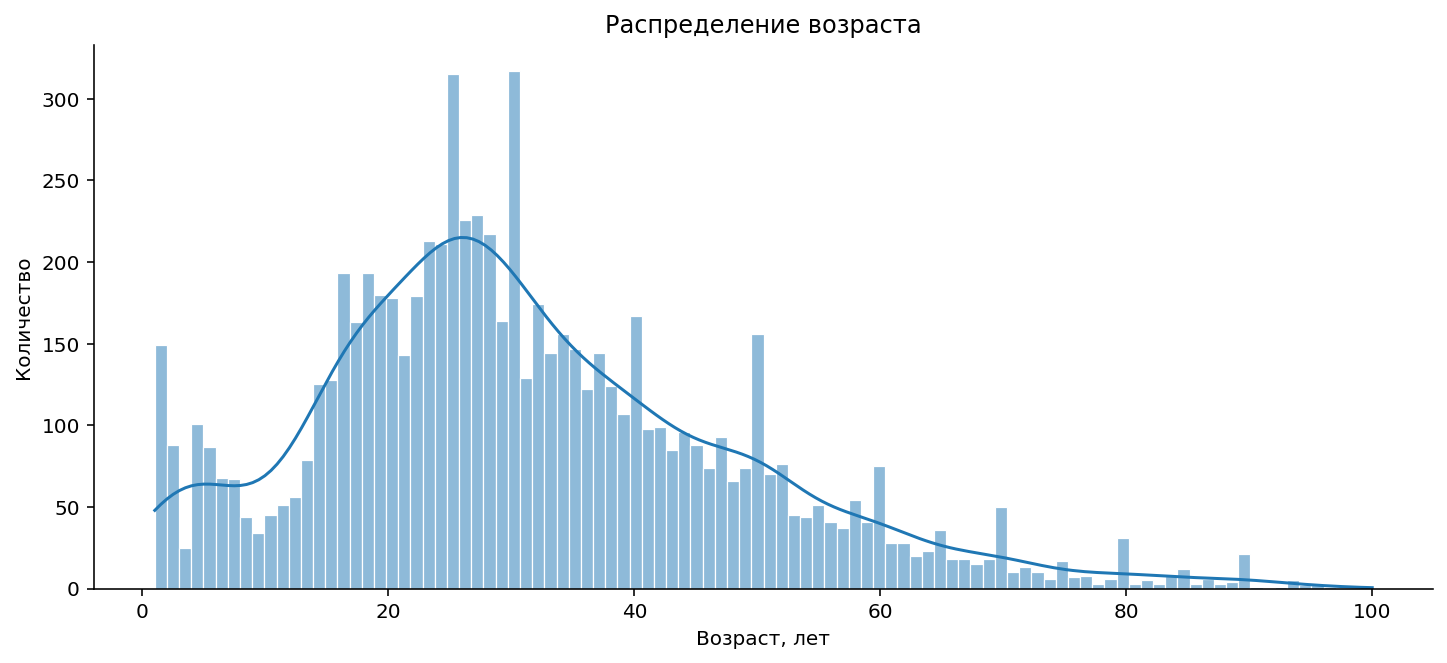

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(
    labels_df['real_age'], bins=100,
    kde=True, kde_kws={'bw_method': 0.2}, 
    edgecolor='white', ax=ax)
ax.set_title('Распределение возраста')
ax.set_xlabel('Возраст, лет')
ax.set_ylabel('Количество')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Мы работаем с фотографиями людей в возрасте от 1 до 100 лет, половина людей находится в диапазоне от 20 до 41 года. Распределение возраста не нормальное.

#### Фотографии

Загрузим фотографии батчами по 32 изображения. Изображения приведем к размеру 224х224 пикселей.

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    labels_df,
    directory=DATA_PATH + 'final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=RANDOM_STATE)

Found 7591 validated image filenames.


Посмотрим на фотографии из первого батча.

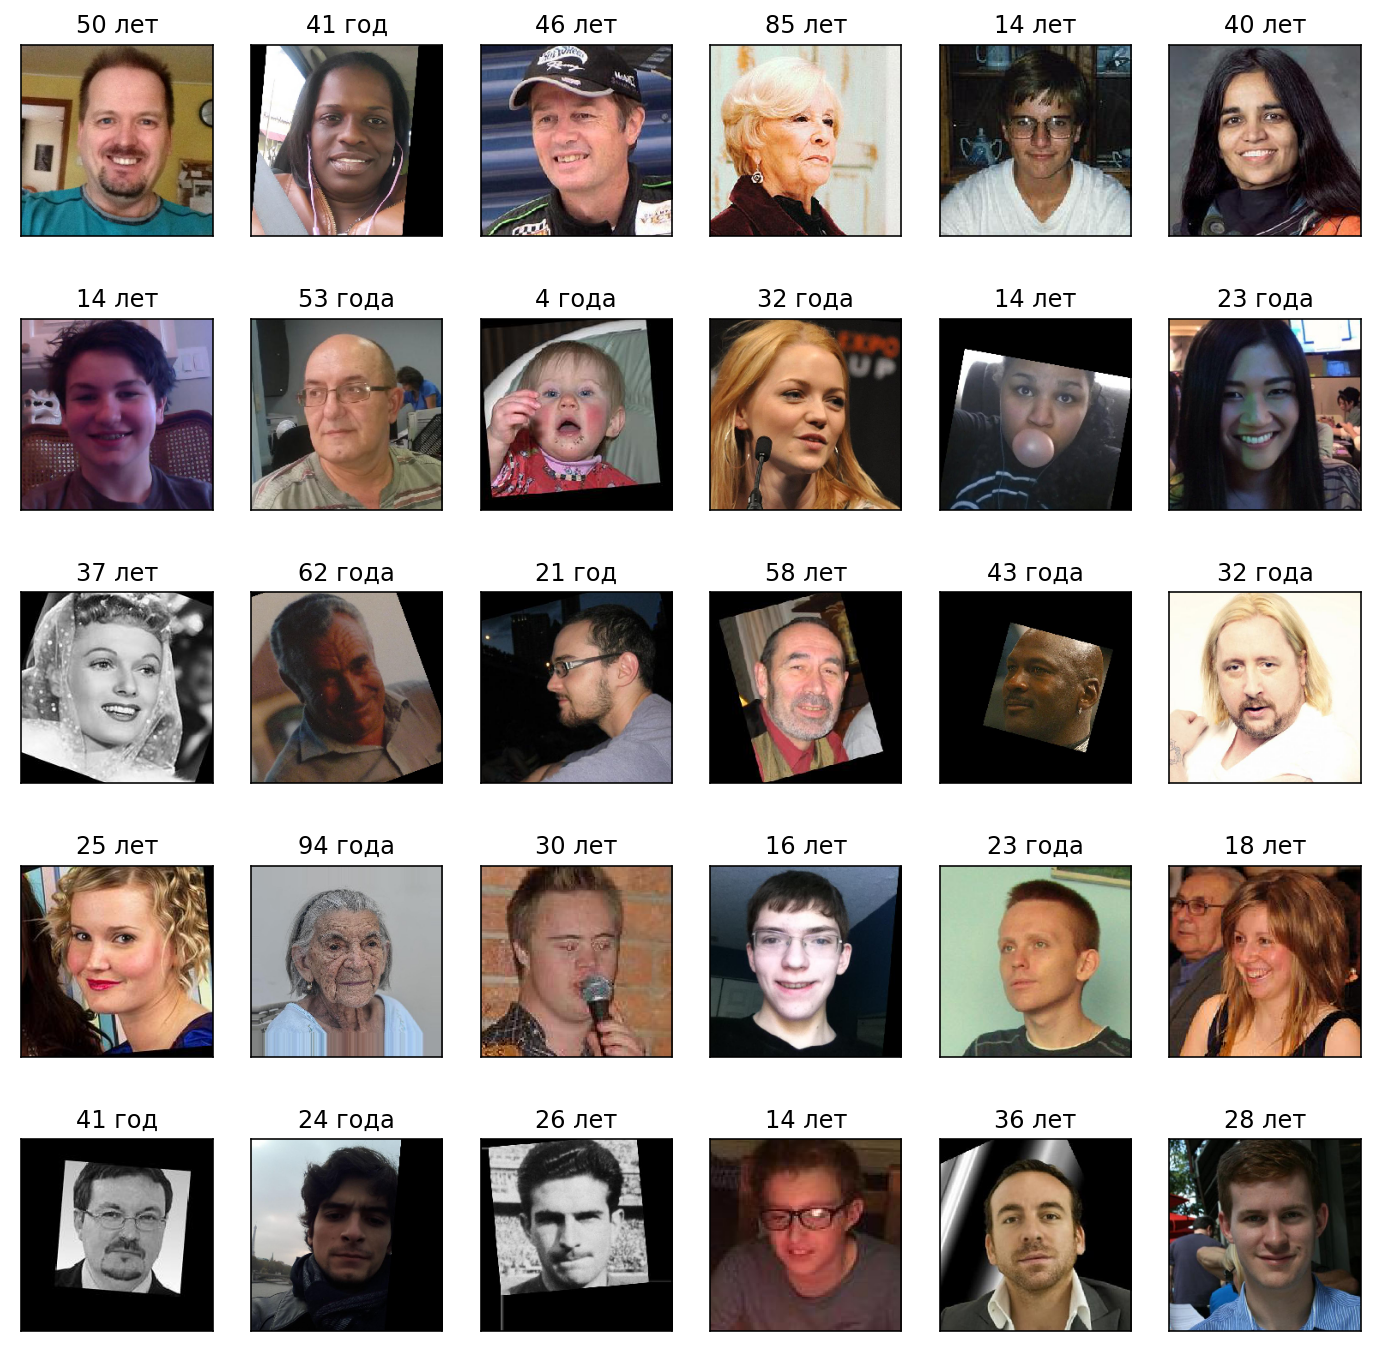

In [13]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.3)

for i in range(30):
    ax = fig.add_subplot(5, 6, i + 1)
    ax.imshow(features[i])
    ax.set_title(decl_of_num(target[i], ('год', 'года', 'лет')))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

Некоторые фоторграфии слегка повернуты, но в основном лица расположены вертикально. Есть фото с обрезнанными или частично закрытыми лицами, присутствуют фотографии людей в головных уборах. При этом стоит ометить, что носы в основном отцентрированы.

## Обучение моделей

### Модель на основе ResNet50

Построим модель на основе сети ResNet50, предобученной на датасете ImageNet, которая по фотографии определит приблизительный возраст человека. В качестве последних слов будем использовать: GlobalAveragePooling2D, Dropout для снижения переобучения и Dense с одним нейроном и активацией ReLU. 

#### Подготовка и обучение

Объявим необходимые функции.

In [14]:
def load_data(path, subset):
    labels_df = pd.read_csv(path + '/labels.csv')

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    datagen_flow = datagen.flow_from_dataframe(
        labels_df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(224, 224),
        batch_size=32,
        shuffle=False,
        subset=subset,
        seed=RANDOM_STATE)

    return datagen_flow


def load_train(path):
    return load_data(path, 'training')


def load_test(path):
    return load_data(path, 'validation')


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5, seed=RANDOM_STATE))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001), 
        loss='mean_squared_error', metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    print('Predict values: ', ', '.join(str(x[0]) for x in model.predict(test_data)))
    
    return model

Загрузим тренировочную и тестовую выборки с фотографиями.

In [15]:
train_datagen_flow = load_train(DATA_PATH)
test_datagen_flow = load_test(DATA_PATH)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Создадим модель.

In [17]:
model = create_model(train_datagen_flow.next()[0][0].shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


Обучим модель в GPU-тренажёре, выведем результаты.

```
Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 56s - loss: 270.7915 - mae: 11.8965 - val_loss: 1037.6668 - val_mae: 27.6667
Epoch 2/10
178/178 - 47s - loss: 74.1741 - mae: 6.5059 - val_loss: 922.1721 - val_mae: 25.5350
Epoch 3/10
178/178 - 48s - loss: 41.5565 - mae: 4.9364 - val_loss: 390.3073 - val_mae: 14.8048
Epoch 4/10
178/178 - 47s - loss: 30.2757 - mae: 4.2266 - val_loss: 122.6643 - val_mae: 8.7824
Epoch 5/10
178/178 - 47s - loss: 23.5154 - mae: 3.7427 - val_loss: 91.4393 - val_mae: 7.1974
Epoch 6/10
178/178 - 47s - loss: 20.3722 - mae: 3.4537 - val_loss: 72.7585 - val_mae: 6.4330
Epoch 7/10
178/178 - 47s - loss: 16.8880 - mae: 3.1152 - val_loss: 74.9335 - val_mae: 6.5997
Epoch 8/10
178/178 - 49s - loss: 15.1059 - mae: 2.9202 - val_loss: 73.9829 - val_mae: 6.4334
Epoch 9/10
178/178 - 48s - loss: 13.2474 - mae: 2.7400 - val_loss: 71.8202 - val_mae: 6.5191
Epoch 10/10
178/178 - 47s - loss: 12.0063 - mae: 2.5967 - val_loss: 70.9578 - val_mae: 6.3535

60/60 - 12s - loss: 70.9578 - mae: 6.3535

Predict values: 9.152902, 29.58891, 77.075195, 49.044525, ...
```

#### Результаты

В результате обучения за 10 эпох модель достигла метрики качества *MAE*=6.35 лет на тестовой выборке (то есть модель удовлетворяет требования заказчика). Посмотрим на распределение остатков модели.

In [18]:
predict_test = [9.152902, 29.58891, 77.075195, 49.044525, 22.34341, 23.269955, 26.749367, 36.299747, 19.00038, 30.004549, 24.779276, 44.967117, 3.325105, 7.1260734, 6.0070186, 10.996323, 35.629257, 19.792288, 40.35344, 16.89248, 28.995216, 4.01616, 33.84736, 31.471884, 4.069348, 15.367354, 18.655405, 33.2409, 59.17792, 20.43759, 2.3438518, 14.442195, 33.478943, 21.478386, 4.07823, 20.38523, 9.457502, 33.985134, 11.069966, 4.0118523, 2.1515977, 22.947283, 19.461432, 21.66382, 16.811586, 24.142347, 31.814554, 25.057999, 33.242702, 17.110514, 37.084743, 20.600235, 16.01418, 7.244894, 35.81628, 19.953491, 33.171795, 17.882092, 16.01767, 16.488688, 35.587368, 23.737877, 32.430172, 22.504753, 23.639431, 29.728266, 66.88725, 29.653078, 5.0393105, 19.859747, 32.106544, 39.0587, 26.196795, 15.88475, 17.010647, 27.115234, 17.22022, 17.342817, 13.606834, 5.5046597, 22.725471, 23.271738, 25.731165, 27.473038, 52.187336, 27.057055, 22.398668, 22.722906, 26.388765, 44.95659, 27.484829, 25.6631, 32.53749, 62.086803, 27.061594, 14.150214, 45.139034, 39.52747, 36.37463, 27.994238, 12.850866, 18.07186, 52.791183, 26.738405, 37.71278, 61.986366, 35.7743, 25.790976, 23.252956, 14.055935, 17.036663, 38.503033, 38.62093, 19.814297, 39.86812, 77.63875, 19.188795, 15.820718, 12.215393, 63.91852, 50.075275, 23.743288, 14.940475, 15.4019, 20.644815, 29.247965, 33.137817, 25.565456, 27.746918, 17.493692, 4.243167, 65.482445, 47.73319, 27.199715, 45.558784, 23.346754, 40.451023, 43.499706, 30.603807, 17.238369, 32.54474, 29.657745, 47.09038, 4.1170516, 16.092335, 7.585078, 19.24724, 6.8992233, 29.249865, 54.84136, 37.152752, 6.6004252, 28.643013, 18.75539, 28.566132, 70.205894, 32.854534, 40.057568, 3.5169597, 19.39222, 26.595806, 28.075466, 34.311806, 39.542934, 39.73541, 37.98485, 27.866333, 67.17826, 17.58911, 31.183256, 26.470215, 32.988144, 24.90395, 22.90248, 45.69214, 56.976444, 38.63753, 20.614746, 8.873968, 19.749292, 25.938211, 19.28837, 27.340036, 25.173668, 23.15621, 24.923874, 18.80765, 13.042011, 26.960407, 40.48514, 68.85644, 45.319115, 28.08013, 58.115253, 24.346987, 23.007902, 23.551855, 15.122512, 11.055868, 17.760813, 13.19146, 32.672134, 18.636429, 12.726513, 11.454293, 41.24835, 35.395306, 19.22183, 19.613064, 18.22511, 22.41868, 22.631075, 17.164743, 17.792477, 26.673536, 22.835264, 26.312935, 11.588314, 4.1475425, 14.550748, 14.020776, 19.218931, 42.738735, 15.277394, 48.78702, 24.665949, 23.163464, 37.19181, 45.886173, 39.254726, 37.50712, 39.64631, 25.879173, 11.821332, 32.866104, 24.82194, 6.5822616, 23.280607, 1.5531482, 19.397596, 36.894318, 45.50284, 28.828661, 22.4038, 35.31957, 29.485012, 21.58297, 26.247536, 23.613907, 14.826407, 10.701719, 1.7782059, 34.527187, 19.142635, 41.68078, 55.591476, 37.073067, 31.031847, 7.4388113, 27.57814, 19.72976, 22.691454, 31.565664, 32.10355, 18.434534, 48.273327, 14.225852, 19.782999, 15.721388, 13.502765, 19.919138, 34.99517, 17.121162, 17.172081, 35.257286, 19.38053, 61.662346, 27.413992, 35.131172, 14.124536, 42.197353, 64.08647, 28.986015, 26.988056, 16.983023, 40.46575, 38.45698, 28.976927, 46.974766, 23.364353, 30.420383, 46.572563, 29.336777, 30.611305, 12.320417, 34.181644, 18.306154, 20.39231, 45.731133, 19.842289, 28.663336, 30.929903, 20.252129, 13.192659, 10.867165, 21.933495, 22.18356, 19.077219, 12.184181, 25.808739, 31.020273, 64.53485, 9.930433, 55.04036, 26.430267, 14.874029, 27.50979, 22.651167, 26.343958, 26.196947, 26.057777, 32.712543, 32.750446, 2.509632, 58.919857, 23.339712, 2.122512, 16.034082, 15.552691, 20.551926, 61.6944, 21.527163, 19.284723, 33.43462, 25.611557, 7.7645736, 35.749176, 48.8587, 31.610088, 16.689386, 11.659109, 25.873825, 32.80631, 14.482922, 13.583737, 39.396107, 17.205273, 15.204526, 29.054113, 49.403843, 21.642616, 29.11416, 29.638123, 49.84532, 39.761574, 23.974787, 26.249111, 2.4585564, 25.35867, 29.69128, 6.8759995, 22.644915, 3.2673628, 27.23045, 16.967241, 29.659708, 18.35359, 40.410954, 26.071938, 29.798048, 24.920458, 25.660856, 41.874348, 25.50809, 41.6798, 40.038036, 4.293537, 31.882244, 24.275675, 52.539448, 31.780132, 42.712414, 22.355473, 20.262428, 17.367374, 50.54391, 21.512281, 38.7873, 26.808372, 77.804726, 17.374815, 13.253587, 21.230495, 13.916419, 23.373278, 25.62944, 2.1913888, 3.8750324, 39.24536, 25.483324, 35.415295, 21.99971, 43.976597, 38.240128, 31.393427, 30.103775, 32.374424, 11.591501, 26.662859, 8.469214, 27.981913, 16.817411, 57.509224, 34.577496, 23.215342, 25.66424, 38.41449, 44.17308, 13.719217, 34.368332, 22.318214, 23.974152, 27.204554, 20.402555, 30.327873, 19.095894, 18.046263, 42.753906, 21.16554, 23.245161, 26.3734, 24.665094, 22.800915, 29.99531, 26.074024, 54.315292, 31.123869, 46.85083, 4.5803347, 31.178873, 41.806595, 35.072598, 30.380262, 10.885635, 3.5264003, 39.464924, 36.34439, 18.101044, 1.1959826, 25.19861, 28.025242, 23.962708, 10.739627, 15.973446, 23.549568, 14.971085, 51.1183, 37.434177, 35.501957, 1.6896487, 28.840242, 52.871746, 0.3859696, 24.067398, 31.36282, 20.76415, 24.920391, 24.965872, 19.177574, 42.685764, 37.26355, 3.3069255, 70.36814, 25.612764, 6.076824, 19.312344, 34.94209, 23.98762, 45.628304, 43.652676, 35.52612, 40.97285, 3.9760058, 14.08278, 20.557848, 30.667376, 25.157032, 29.73776, 29.39213, 24.02527, 31.323088, 25.348162, 24.496555, 44.947357, 38.298794, 24.688087, 38.867134, 5.784874, 31.067463, 25.936094, 25.800314, 44.71471, 17.075798, 18.440676, 21.597143, 31.040506, 39.45419, 25.417377, 28.754107, 14.772597, 22.795765, 19.280287, 50.167606, 20.829258, 35.779366, 57.962887, 34.97592, 23.500486, 31.850048, 24.62175, 15.934389, 22.239777, 30.668158, 9.992327, 22.763502, 38.65614, 18.967361, 19.510626, 30.865267, 6.355615, 43.98348, 4.3835053, 26.546568, 66.64044, 67.95438, 18.826258, 21.352777, 15.318834, 27.438543, 34.63773, 25.929369, 21.062937, 28.983747, 30.15194, 12.116868, 31.571402, 40.442963, 22.397472, 28.054588, 27.385447, 16.584425, 45.6705, 16.302029, 18.069252, 59.269943, 27.243862, 21.406506, 53.107586, 21.780363, 44.47098, 38.101097, 38.685604, 23.398893, 7.9775767, 6.526208, 14.2106905, 29.56038, 28.438372, 37.167576, 45.67108, 32.055904, 29.325235, 17.63059, 26.569609, 21.171066, 5.415478, 25.458136, 22.895617, 17.545702, 27.54422, 7.4403477, 28.172955, 26.630384, 18.224895, 39.8434, 18.18296, 33.61877, 22.257442, 24.272762, 14.974586, 48.619053, 11.183265, 18.39584, 5.992232, 23.053701, 9.327811, 21.359234, 38.47431, 33.657494, 21.87565, 50.03767, 75.17117, 7.5325594, 21.147202, 18.762197, 22.712582, 20.420984, 17.958038, 28.09509, 4.8100295, 19.444918, 31.710354, 26.846266, 57.38016, 10.984941, 29.22724, 23.110723, 22.164202, 21.518309, 13.211087, 39.678844, 32.374016, 63.887493, 25.731575, 20.908552, 29.04893, 32.428864, 22.96018, 34.863285, 29.156271, 17.888836, 50.417423, 26.490929, 15.828806, 21.255375, 21.710566, 27.319635, 22.641478, 28.824371, 29.172255, 5.229308, 22.762812, 17.1522, 20.128277, 18.43682, 3.1565442, 33.97795, 20.645882, 15.576533, 25.309977, 20.886703, 50.58923, 30.17696, 20.208652, 52.613304, 34.359688, 22.322903, 24.461191, 28.780863, 8.812424, 19.178026, 27.607008, 24.743687, 25.381144, 26.070463, 32.277946, 25.355268, 1.8250539, 17.29767, 47.297714, 44.66701, 27.203337, 20.110945, 39.47857, 1.5407186, 32.04021, 65.25323, 31.730772, 46.553894, 31.948675, 26.269966, 24.716124, 14.973163, 22.737686, 5.9354086, 52.0822, 27.767084, 17.941437, 38.71713, 32.518383, 28.506681, 21.49183, 21.706392, 32.444283, 24.817286, 35.052704, 19.195421, 13.30712, 15.4081135, 8.539844, 18.561558, 34.63234, 14.76802, 25.64452, 14.436265, 36.991306, 42.966637, 23.372713, 16.241, 45.026634, 21.496836, 16.858091, 29.874355, 42.4327, 29.71871, 23.668993, 9.822239, 49.772266, 18.90598, 23.479364, 54.61542, 23.588877, 3.7392046, 26.638163, 35.688076, 31.454283, 9.122588, 18.394571, 20.43469, 5.329212, 5.7027264, 23.004602, 24.876228, 32.010403, 18.995657, 27.240097, 36.901756, 27.741241, 30.02718, 14.726082, 33.76829, 19.081194, 3.7964451, 23.496338, 21.91014, 36.06388, 49.01154, 22.483864, 34.83397, 34.58901, 14.091479, 28.020157, 17.411558, 5.79581, 18.650425, 35.370712, 11.456986, 24.475903, 21.160034, 30.620893, 16.414715, 22.411541, 9.742045, 18.40945, 26.452803, 29.241562, 42.93667, 37.983986, 31.396973, 27.555561, 12.928528, 22.017078, 18.823792, 1.7710232, 25.252695, 15.945761, 23.518137, 32.00739, 29.55181, 77.27719, 9.237574, 31.394138, 37.593952, 10.215136, 47.864655, 19.790306, 25.772972, 30.902723, 26.65873, 34.256435, 23.312302, 17.975351, 59.43784, 22.751776, 29.129467, 17.637451, 27.697231, 17.419619, 19.774416, 24.332243, 2.5234523, 40.8137, 24.895248, 5.1508102, 35.849094, 35.53485, 34.471066, 37.88024, 27.479624, 24.967213, 15.928009, 25.277828, 30.534554, 38.944927, 31.054457, 29.859724, 35.51564, 49.164955, 22.973436, 24.471363, 23.593761, 18.526844, 21.9272, 35.184433, 62.45636, 88.82996, 23.66085, 21.396666, 29.452934, 20.226828, 17.070795, 47.327934, 35.212387, 16.56472, 19.967007, 18.161558, 17.831387, 31.598175, 48.66318, 36.287384, 14.074414, 31.895147, 22.036068, 26.191038, 41.63893, 26.35157, 22.633984, 28.84262, 24.25419, 23.17153, 18.570522, 73.3735, 52.905373, 46.048264, 14.150826, 51.249184, 37.25453, 22.973473, 30.780127, 31.485668, 43.58477, 58.475613, 21.923275, 22.499079, 45.818733, 17.75777, 24.330564, 36.67252, 27.068562, 24.831392, 36.71545, 25.93854, 24.739428, 31.232653, 61.81389, 6.9274836, 38.80493, 68.707306, 17.613104, 18.858671, 39.788277, 35.657375, 22.43515, 7.913665, 25.579695, 22.964577, 28.685246, 17.811857, 42.479168, 12.419031, 27.539795, 21.43799, 48.119076, 12.398474, 25.066921, 29.884058, 24.721706, 56.67673, 18.200094, 4.54345, 32.102047, 38.3411, 30.009012, 17.569233, 6.064667, 8.753676, 46.475143, 4.277485, 5.3785386, 19.337568, 15.867587, 23.146294, 20.940876, 13.502001, 21.798855, 46.27129, 9.939486, 23.073591, 15.247833, 30.96351, 44.60889, 38.37985, 16.528055, 30.068182, 36.5309, 17.027777, 17.780903, 27.08943, 28.106869, 28.500423, 24.141596, 55.288067, 40.566532, 42.440395, 4.7455435, 32.97463, 31.898993, 17.24945, 28.189548, 58.975346, 32.598938, 21.536682, 18.813057, 8.891989, 34.974415, 18.64871, 12.181965, 37.349266, 26.127443, 48.963253, 22.789373, 78.28581, 24.056494, 58.332054, 21.62434, 22.98646, 33.148872, 16.19011, 28.681337, 24.531467, 18.521748, 37.71122, 39.190166, 26.357517, 31.148542, 10.390845, 27.178871, 15.42428, 23.930868, 23.964016, 23.703186, 28.185783, 19.417122, 17.093723, 24.258919, 18.727781, 29.900763, 11.385911, 34.135426, 24.886747, 15.839741, 37.804256, 16.767708, 16.081821, 5.1985335, 38.914482, 46.06237, 54.376797, 33.68955, 29.826881, 25.072634, 0.36687976, 19.419668, 34.86642, 33.608, 35.532402, 22.541193, 20.485083, 26.084757, 21.508104, 19.978401, 31.213436, 62.371315, 36.076, 18.618593, 5.827913, 29.266977, 18.609425, 1.3986981, 21.149996, 27.258537, 21.486519, 16.481485, 24.134714, 55.254597, 25.018875, 23.183878, 13.24337, 31.902441, 18.910336, 16.264315, 26.717981, 22.787378, 32.897358, 26.118307, 20.137318, 45.888527, 18.361792, 21.255985, 23.198008, 15.5478525, 37.5409, 35.81054, 14.201567, 38.88015, 24.495293, 29.553274, 31.376638, 30.445295, 10.942738, 14.837958, 33.985783, 25.527693, 10.774559, 23.092484, 49.3752, 19.530045, 25.09325, 30.40827, 4.772579, 24.656277, 43.022175, 61.66473, 14.686933, 14.669432, 20.594753, 15.579278, 31.976088, 14.072039, 23.969513, 36.14573, 23.527891, 15.918125, 25.360874, 19.33152, 81.91595, 27.074703, 30.38325, 19.58863, 78.10502, 17.490133, 6.395514, 42.76723, 21.578836, 50.966484, 26.408272, 7.329045, 27.552063, 3.6185758, 30.942904, 55.54539, 17.67087, 19.564201, 33.506996, 30.000118, 14.965855, 60.098007, 65.93267, 40.409473, 28.957111, 33.17904, 30.3797, 28.888601, 18.61218, 22.40665, 33.114307, 30.634533, 30.666803, 32.19279, 7.5588512, 32.492943, 13.798923, 24.33543, 28.233797, 27.128265, 29.520437, 31.167845, 50.729515, 34.914467, 24.877, 19.58363, 13.599969, 28.179947, 16.029348, 49.956593, 16.83757, 32.65172, 20.962263, 24.100048, 13.421518, 43.64315, 25.099997, 15.047283, 27.985466, 24.59848, 23.048607, 60.989334, 28.699953, 7.632428, 26.498686, 20.886444, 12.112753, 21.069286, 62.63081, 27.9444, 14.440807, 2.4364467, 17.40234, 15.712214, 16.641792, 24.10075, 0.0, 31.850563, 23.889507, 30.679722, 5.473859, 35.004448, 55.589897, 31.892511, 19.678005, 31.364391, 35.014267, 33.722477, 21.768667, 28.229591, 19.273571, 29.723242, 25.879875, 21.350939, 15.527821, 52.472813, 51.493835, 18.773027, 3.7029254, 12.765543, 24.552647, 15.88108, 35.584763, 78.33356, 45.838264, 19.572742, 24.164015, 16.396742, 46.719856, 19.586355, 29.766335, 11.360929, 31.963293, 21.323051, 69.19401, 23.169819, 11.218928, 31.753706, 31.7472, 25.252758, 24.946375, 40.738647, 21.606121, 25.589146, 36.862083, 28.351027, 47.637, 26.493292, 67.627716, 53.008484, 37.30726, 24.820055, 23.34145, 66.41684, 27.996916, 26.920494, 28.909285, 35.03226, 23.02859, 51.173035, 38.30697, 17.50236, 46.556835, 34.7133, 24.821018, 31.757439, 1.7049325, 39.636673, 23.806437, 32.969833, 24.655075, 76.13712, 33.946278, 28.577211, 22.842796, 14.096838, 12.619984, 27.482391, 24.471714, 52.532337, 13.917138, 4.85989, 37.46872, 41.11065, 18.71141, 40.57387, 25.437656, 35.826473, 8.154566, 41.729736, 22.89724, 18.15428, 36.392735, 29.376177, 58.732536, 15.80175, 14.278155, 43.116753, 20.714891, 22.66731, 21.906498, 28.65031, 34.092236, 27.159784, 28.360525, 9.356067, 27.913862, 2.6343374, 29.161213, 14.757238, 38.843636, 55.55176, 46.462666, 27.061253, 2.3996723, 11.563082, 33.174675, 20.10352, 62.256405, 22.482912, 31.511786, 69.10109, 24.851988, 24.923553, 54.261894, 17.111706, 39.94015, 39.962353, 23.67317, 27.564901, 29.499048, 19.559752, 21.335733, 11.70022, 31.666962, 25.798899, 43.68138, 28.127556, 16.844893, 23.938768, 17.24708, 20.592882, 28.112846, 51.60634, 46.65995, 28.632704, 21.829035, 25.020172, 22.904467, 22.627829, 14.730557, 25.47533, 20.442068, 19.823895, 26.393831, 19.341846, 37.98657, 37.395775, 27.545422, 15.2169485, 24.203224, 36.92656, 54.728283, 27.260862, 24.627478, 20.178768, 34.238552, 17.07871, 54.90755, 27.968931, 10.938831, 34.260418, 8.239359, 27.966074, 23.292738, 40.69596, 15.089653, 35.489017, 48.46148, 0.0, 18.098066, 43.88513, 21.916512, 33.729053, 22.01835, 21.531612, 21.006054, 17.163887, 22.298605, 55.590076, 8.551191, 26.48317, 30.592499, 13.065344, 24.706379, 38.167545, 20.874975, 37.343884, 24.322609, 20.54921, 15.499363, 28.990732, 30.2721, 43.755123, 19.803196, 19.19765, 23.00174, 45.99348, 22.148386, 60.722725, 68.032234, 33.314354, 39.309525, 12.918979, 21.594997, 11.011556, 68.41103, 52.770313, 31.283314, 54.30781, 25.995132, 34.18531, 31.491718, 18.25459, 27.10183, 3.2759564, 51.435966, 6.8281093, 22.856604, 22.39456, 40.49474, 31.899303, 32.251198, 23.504427, 40.22357, 0.6024083, 18.444763, 32.90795, 38.385906, 31.965977, 38.303627, 35.988037, 10.485848, 28.635803, 7.959535, 28.732187, 31.078613, 20.390163, 38.482895, 30.168999, 21.46839, 7.9062757, 37.617966, 25.439617, 19.976273, 17.408464, 21.991623, 35.602463, 20.527948, 24.548096, 26.5338, 69.581474, 33.99996, 47.374935, 3.8074775, 46.62472, 26.52554, 16.510319, 51.391384, 25.014408, 18.560919, 11.736394, 18.823551, 36.744846, 18.890692, 30.022562, 28.486752, 24.120914, 20.684334, 51.22222, 20.510948, 34.956127, 24.612867, 23.180141, 6.504681, 22.062132, 21.058807, 4.114035, 18.583086, 75.55139, 4.7350693, 17.590847, 32.193478, 19.749338, 21.795576, 20.991394, 22.527662, 2.771679, 17.410328, 46.19842, 19.172083, 45.003345, 17.574873, 40.72266, 11.919578, 27.805285, 19.394358, 43.709164, 26.799124, 42.28771, 8.594462, 36.67063, 32.51281, 38.14501, 30.358528, 26.326292, 21.889421, 35.61582, 12.256399, 16.921638, 5.218995, 32.743713, 23.398964, 24.660524, 26.487577, 19.705204, 18.055119, 19.433935, 28.982073, 15.163252, 26.039051, 18.163155, 28.359226, 22.58796, 32.52659, 22.618322, 0.17397395, 34.638947, 18.214853, 7.465327, 32.39977, 43.796993, 72.77431, 31.42144, 35.236317, 28.13864, 33.914856, 13.591993, 44.233273, 28.189316, 15.814259, 6.8895226, 32.01289, 26.780851, 33.114517, 31.300985, 57.482292, 19.321203, 70.46248, 16.217222, 17.475552, 16.517996, 37.850742, 21.741386, 37.121655, 38.969387, 59.418316, 1.245805, 28.589994, 22.88467, 25.312, 22.267885, 18.014633, 30.634056, 30.347681, 41.319912, 21.343843, 34.98629, 17.388462, 22.955004, 19.182533, 28.06515, 24.456995, 45.737637, 48.90797, 30.689102, 26.865599, 30.393564, 68.69277, 30.087374, 24.709301, 51.206573, 28.145895, 34.644722, 23.625536, 27.474035, 10.254558, 19.212769, 27.383657, 18.030428, 22.802795, 64.07945, 34.85288, 31.34805, 25.765879, 22.248716, 23.051405, 19.42741, 27.898321, 32.807392, 30.492796, 25.092592, 31.24759, 52.55449, 21.964499, 24.20941, 51.307117, 54.66428, 18.688595, 22.01061, 13.87023, 15.972643, 19.505213, 26.510134, 27.353529, 38.885056, 45.43436, 26.034466, 30.381601, 27.17193, 35.543156, 21.878313, 31.763382, 30.526413, 10.870859, 20.038855, 32.73591, 25.358847, 22.092495, 19.10262, 16.529398, 26.108088, 38.600178, 2.8626957, 48.89822, 13.200035, 21.217958, 21.970943, 25.832573, 34.583065, 20.698225, 21.263273, 30.11195, 10.580694, 40.055325, 22.3244, 46.4238, 7.733448, 31.001688, 34.871796, 24.881607, 54.04987, 26.17015, 42.055954, 34.98121, 46.6079, 38.574543, 1.6417654, 45.097095, 14.953077, 23.589338, 23.716877, 16.030754, 16.056458, 32.802563, 18.169762, 21.86688, 17.754538, 6.8157797, 27.77614, 21.719805, 21.303818, 39.476048, 15.617384, 28.110214, 22.28514, 24.19254, 17.766848, 21.70571, 28.645178, 48.149357, 23.926153, 27.885448, 23.354181, 39.25638, 65.27602, 29.06129, 22.043587, 23.943604, 14.989183, 22.347372, 13.979492, 22.450077, 24.46583, 11.29209, 15.841771, 7.549537, 25.66242, 30.580692, 52.238632, 30.605778, 39.075222, 19.608269, 16.688889, 31.205008, 20.935408, 33.186195, 1.5397483, 49.603943, 30.978918, 13.871158, 13.733615, 27.772451, 19.950863, 16.601574, 23.96102, 29.168291, 19.855242, 27.83991, 21.736465, 30.268751, 27.24556, 19.711552, 44.38276, 40.933475, 50.280174, 43.03252, 40.227764, 32.375004, 6.3047314, 16.667152, 61.305576, 37.762672, 49.887737, 44.259068, 29.676683, 33.156246, 3.2268987, 39.169365, 21.880663, 3.6477692, 19.312664, 36.416412, 29.628738, 31.689737, 24.795477, 17.154984, 27.242037, 18.256903, 21.168863, 60.799618, 16.355303, 20.407187, 23.20106, 35.988087, 22.928905, 63.1706, 30.27923, 24.58857, 28.65706, 16.675047, 37.596355, 26.106802, 27.115786, 20.33738, 36.593815, 36.477924, 28.923508, 29.05092, 67.0972, 3.148803, 22.186277, 32.763416, 14.338189, 50.455517, 14.325987, 22.896107, 62.992825, 31.756702, 20.051113, 38.5335, 11.416868, 63.263367, 26.375828, 22.657892, 50.975273, 24.534431, 37.79517, 22.189556, 17.097204, 30.190039, 20.932356, 20.345757, 23.510399, 38.775715, 8.668046, 35.56367, 15.847415, 1.7982872, 29.249908, 34.850952, 8.921465, 28.587042, 22.124376, 19.116034, 19.601358, 27.04719, 31.492622, 24.04352, 39.453735, 48.52023, 31.72275, 24.135971, 20.249008, 30.282286, 31.964836, 42.910076, 23.009785, 20.03908, 43.875698, 25.191853, 21.625746, 41.111774, 26.939373, 24.60406, 34.853573, 2.8761737, 21.208853, 27.173971, 41.32339, 39.27203, 59.585327, 16.947546, 18.95144, 39.51125, 59.332684, 34.462654, 30.88086, 36.672382, 16.267683, 54.065952, 20.565575, 25.296616, 26.641502, 32.01011, 25.345802, 25.205837, 17.148397, 28.23313, 58.582214, 29.812119, 15.867871, 21.327265, 24.117321, 24.945452, 33.106567, 35.1515, 5.5386786, 37.549202, 52.098026, 27.430374, 45.95019, 26.202234, 4.892514, 33.928215, 20.839424, 30.490438, 50.241554, 6.38943, 66.29466, 76.48902, 36.125717, 30.766981, 25.501966, 13.865207, 24.13395, 27.379812, 18.132908, 28.499142, 52.43208, 29.794315, 42.935192, 75.84146, 20.03358, 23.94463, 23.51379, 47.56974, 73.91426, 23.850866, 40.30728, 7.227098, 27.661709, 44.477142, 26.195593, 15.229774, 33.67798, 28.241516, 31.006073, 31.534664, 18.916634, 7.498641, 10.281431, 24.7782, 4.84208, 19.508253, 51.48173, 37.62634, 13.567867, 34.520836, 39.56015, 26.545364, 23.093098, 20.717714, 13.207946, 27.244665, 26.349413, 14.09031, 33.518093, 33.982548, 33.963505, 21.542135, 27.590145, 30.65819, 46.309944, 27.91403, 19.693636, 33.311905, 18.799078, 15.132552, 67.625465, 26.475065, 34.46139, 37.16582, 38.649567, 17.414455, 18.761486, 18.835886, 34.455593, 22.165136, 27.11497, 17.74147, 22.607471]
f'{mean_absolute_error(test_datagen_flow.labels, predict_test):.4f} лет'

'6.3535 лет'

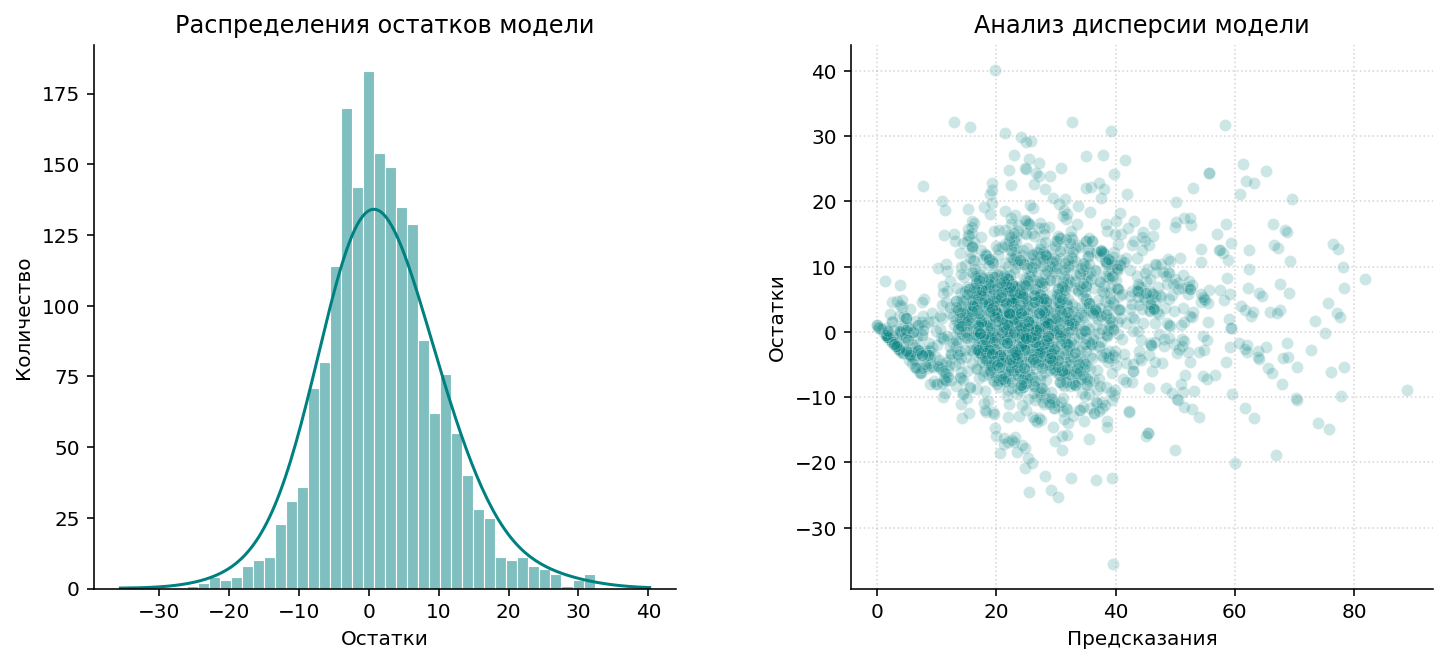

In [19]:
residuals = test_datagen_flow.labels - predict_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

sns.histplot(x=residuals, ax=ax1, kde=True, kde_kws={'bw_method': 0.6}, 
             color='teal', edgecolor='white')
ax1.set_title(f'Распределения остатков модели')
ax1.set_xlabel('Остатки')
ax1.set_ylabel('Количество')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.scatterplot(x=predict_test, y=residuals, ax=ax2, color='teal', alpha=0.2)
ax2.set_title(f'Анализ дисперсии модели')
ax2.set_xlabel('Предсказания')
ax2.set_ylabel('Остатки')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(alpha=0.5, linestyle=':')

plt.show()

Распределение остатков близко к нормальному со средним около 0.

### Модель на основе InceptionResNetV2

Построим модель на основе сети InceptionResNetV2, предобученной на датасете ImageNet. Последние слои возъмём как у предыдущей модели: GlobalAveragePooling2D, Dropout для снижения переобучения и Dense с одним нейроном и активацией ReLU. 

#### Подготовка и обучение

Объявим необходимые функции.

In [21]:
def create_model(input_shape):
    backbone = InceptionResNetV2(
        input_shape=input_shape,
        include_top=False, 
        weights='imagenet')
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5, seed=RANDOM_STATE))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='mean_squared_error', metrics=['mae'])
    
    return model

Создадим модель.

In [22]:
model = create_model(train_datagen_flow.next()[0][0].shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54,338,273
Trainable params: 54,277,729
Non-trainable params: 60,544
_________________________________________________________________


Обучим модель в GPU-тренажёре, выведем результаты.

```
Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 109s - loss: 288.4588 - mae: 12.6804 - val_loss: 2854.6331 - val_mae: 32.7163
Epoch 2/10
178/178 - 68s - loss: 126.6037 - mae: 8.5668 - val_loss: 144.3718 - val_mae: 9.0730
Epoch 3/10
178/178 - 72s - loss: 85.6905 - mae: 7.0710 - val_loss: 91.2147 - val_mae: 7.4434
Epoch 4/10
178/178 - 61s - loss: 58.7538 - mae: 5.9045 - val_loss: 131.8242 - val_mae: 8.6831
Epoch 5/10
178/178 - 72s - loss: 45.3138 - mae: 5.1767 - val_loss: 108.3068 - val_mae: 7.2750
Epoch 6/10
178/178 - 71s - loss: 34.9020 - mae: 4.5345 - val_loss: 83.7714 - val_mae: 6.7732
Epoch 7/10
178/178 - 64s - loss: 27.3371 - mae: 4.0526 - val_loss: 83.5442 - val_mae: 6.7212
Epoch 8/10
178/178 - 72s - loss: 21.1913 - mae: 3.5415 - val_loss: 75.8607 - val_mae: 6.6562
Epoch 9/10
178/178 - 65s - loss: 18.7484 - mae: 3.3095 - val_loss: 70.4755 - val_mae: 6.3046
Epoch 10/10
178/178 - 70s - loss: 16.3573 - mae: 3.0716 - val_loss: 74.0931 - val_mae: 6.4480

60/60 - 12s - loss: 74.0931 - mae: 6.4480

Predict values:  6.909696, 29.458626, 77.74515, 43.233234, ...
```

#### Результаты

В результате обучения за 10 эпох модель достигла метрики качества *MAE*=6.45 лет на тестовой выборке (то есть эта модель тоже удовлетворяет требования заказчика). Посмотрим на распределение остатков модели.

In [23]:
predict_test = [6.909696, 29.458626, 77.74515, 43.233234, 24.004707, 25.253817, 22.164665, 38.80597, 17.70833, 37.85267, 24.902557, 39.961437, 11.876593, 4.1177654, 8.263757, 17.719152, 33.01313, 12.94791, 29.237997, 22.626232, 28.077646, 4.5545673, 27.799007, 24.71164, 6.4193406, 26.674305, 24.442785, 33.14342, 54.361076, 25.37708, 3.6068654, 24.31243, 35.207794, 21.887138, 7.0692196, 19.611752, 10.950418, 32.025696, 18.011536, 4.265008, 2.889581, 18.429216, 19.137247, 27.480824, 18.25155, 24.217321, 33.10332, 23.490347, 47.445034, 24.146618, 33.21841, 17.015377, 25.157635, 2.3703046, 41.423813, 19.009817, 27.18859, 18.238823, 18.767506, 21.321636, 30.470781, 23.052662, 13.101167, 26.045065, 26.261856, 29.909975, 63.743237, 37.064724, 5.7685757, 21.37823, 26.706272, 38.744778, 25.862041, 29.77738, 20.01907, 25.09279, 22.485697, 19.598871, 23.753023, 2.4481063, 24.651293, 29.631393, 20.301165, 29.319895, 53.481445, 29.949903, 36.651703, 26.800701, 29.684359, 36.9363, 23.905737, 20.838, 25.494759, 54.11162, 25.721067, 23.246902, 49.12394, 39.729305, 38.313427, 24.268707, 33.460297, 30.812029, 39.281406, 21.574932, 30.24705, 63.63863, 38.37707, 26.048658, 28.282866, 14.53066, 14.461117, 37.659058, 31.974154, 25.461569, 36.879883, 78.349754, 19.676535, 14.692905, 15.042012, 59.963562, 57.274364, 25.90563, 18.246126, 23.630522, 19.818764, 28.296705, 34.396774, 25.654566, 23.182158, 18.920671, 8.067426, 61.69026, 38.856472, 22.65691, 40.70734, 28.050447, 32.512245, 39.951725, 26.358006, 22.56505, 32.406803, 27.609146, 43.551025, 7.3891253, 22.649513, 12.518452, 23.532246, 10.250907, 25.123823, 40.7536, 35.836456, 4.1249957, 27.13969, 19.340399, 28.385162, 58.131546, 33.755745, 32.257877, 6.103537, 24.408848, 22.319588, 26.397741, 33.574844, 38.18452, 41.943417, 43.376225, 26.728554, 69.91491, 25.291254, 28.896822, 20.896292, 28.219906, 24.92899, 31.730846, 40.32703, 61.60585, 31.758665, 19.816887, 13.527324, 25.863134, 22.86387, 18.72489, 24.362312, 27.028467, 30.588043, 27.36388, 16.954838, 18.369343, 31.604229, 36.09745, 67.41856, 50.08031, 16.72734, 40.110466, 22.939722, 27.574629, 21.240284, 20.112698, 17.120531, 12.658912, 11.668755, 32.44227, 19.511848, 20.177927, 10.229353, 40.556892, 23.499525, 22.42835, 19.735792, 22.05454, 23.728115, 23.274632, 20.347841, 17.619396, 26.114313, 21.280663, 22.1394, 16.075579, 9.402671, 21.267033, 20.245358, 23.385052, 41.229862, 18.829714, 42.23892, 20.992521, 20.979229, 27.678358, 31.474503, 44.334167, 37.244213, 49.9261, 25.419239, 10.153885, 28.759691, 18.246843, 9.954898, 26.014633, 1.1129496, 29.199793, 30.129368, 29.593874, 26.873707, 17.137266, 34.87602, 20.735004, 28.764101, 26.18672, 25.497566, 16.865894, 14.210994, 2.0408106, 28.565578, 24.484035, 36.366604, 57.862198, 33.205624, 37.69644, 11.404247, 19.856174, 23.143543, 25.81133, 27.643887, 33.28378, 13.959084, 37.621017, 20.33147, 19.222656, 24.046333, 19.399755, 19.832958, 32.065556, 19.79636, 21.41605, 29.622326, 21.966839, 55.174435, 20.46533, 32.06567, 9.508517, 28.421864, 68.026535, 32.61813, 28.280834, 18.333414, 41.598137, 42.02449, 20.841293, 44.417408, 17.424576, 33.633213, 42.93771, 26.922298, 33.820835, 18.20832, 27.662554, 21.508274, 17.4037, 51.77876, 19.593863, 33.845745, 30.340313, 25.937622, 20.459108, 16.585741, 23.536907, 19.096373, 22.772858, 13.628871, 23.183758, 23.306622, 66.920975, 3.183192, 48.69931, 23.501987, 18.735432, 30.716938, 23.930462, 26.01967, 27.721346, 30.19148, 22.542439, 26.555433, 2.1098, 58.026833, 25.497349, 2.4355233, 15.865601, 19.937586, 28.706701, 62.276268, 20.273678, 22.280766, 23.39251, 35.454304, 5.7677307, 36.58805, 50.079613, 39.127186, 22.388304, 13.84222, 28.335396, 24.972538, 17.364971, 18.288118, 38.05867, 19.335901, 21.33035, 31.385597, 51.17628, 20.622385, 29.510332, 35.447063, 48.204025, 42.499393, 28.332947, 24.286322, 6.377977, 23.829857, 26.794565, 15.228899, 23.975569, 2.2887435, 25.591074, 20.239447, 33.673534, 20.8396, 35.743866, 25.445467, 25.325127, 21.402256, 27.199419, 44.42535, 20.408985, 41.578564, 22.817278, 3.807799, 31.588625, 17.90804, 60.076424, 35.07954, 41.9795, 22.183455, 19.097086, 22.559147, 43.81271, 21.864244, 43.20756, 28.008337, 74.82982, 19.093603, 15.103152, 26.70253, 18.44511, 24.917639, 23.322176, 5.0684133, 14.243435, 34.26622, 22.144619, 29.22055, 20.265232, 44.115868, 30.71173, 31.953304, 33.527836, 32.931923, 25.909132, 26.438519, 14.20339, 28.055096, 16.985998, 47.78112, 34.7337, 26.596865, 26.848879, 38.847916, 37.923027, 18.26453, 43.57243, 26.109747, 23.679672, 23.380444, 22.450445, 34.3027, 15.447277, 17.953224, 37.212757, 20.415855, 22.735245, 29.237799, 26.760006, 25.92113, 30.536928, 28.581633, 58.798, 28.626143, 45.113075, 8.235258, 36.04867, 42.373962, 45.788696, 24.584642, 12.133267, 3.1856537, 36.43004, 30.269936, 17.604832, 2.0970118, 27.866606, 26.399366, 26.680824, 16.238283, 17.698883, 28.258955, 25.235731, 49.514053, 39.674484, 42.652103, 1.8981066, 20.082935, 53.363686, 3.7520552, 23.291956, 27.595446, 20.654295, 29.03807, 24.375416, 19.624655, 30.162512, 40.067924, 3.441686, 66.50758, 24.042685, 5.319938, 19.36015, 37.402985, 23.851622, 39.309494, 33.517517, 14.888853, 39.29779, 5.1332054, 14.2890625, 22.563543, 23.083231, 20.379698, 27.025219, 15.1882, 24.79053, 29.001524, 17.387407, 20.757248, 38.796246, 35.09008, 20.441898, 39.445953, 5.5002327, 33.830173, 21.875477, 28.37796, 43.033775, 18.430872, 14.847453, 21.428871, 31.089169, 30.607405, 27.079018, 23.306528, 15.20849, 27.824394, 22.185839, 45.286877, 23.575085, 30.295135, 68.32769, 33.685795, 19.966146, 26.632057, 19.79149, 25.489933, 20.352074, 27.570398, 7.0837827, 25.570988, 35.09551, 16.139782, 18.673483, 37.56095, 5.9578557, 46.79566, 3.3961122, 25.381754, 54.51187, 68.8171, 21.176096, 26.505716, 22.193567, 29.406406, 31.175356, 18.58891, 21.34338, 31.346155, 34.935246, 12.918174, 35.585857, 45.641155, 25.610401, 25.788319, 30.645456, 19.999752, 48.599323, 20.233389, 20.519403, 45.04704, 25.896456, 23.086084, 51.112095, 23.713835, 43.322426, 39.733673, 37.073425, 26.510546, 14.166711, 8.668512, 14.275588, 25.160519, 29.569118, 35.393154, 47.297436, 24.411913, 23.417362, 14.228073, 30.301205, 28.649508, 9.120238, 25.74038, 24.269804, 18.090607, 27.275026, 8.937137, 27.365732, 20.833097, 22.916033, 41.710255, 22.297293, 33.071526, 22.705935, 24.830263, 18.558727, 38.33385, 22.302372, 21.667465, 5.1429176, 22.959372, 16.002626, 22.484879, 40.060623, 25.378046, 20.9079, 38.715427, 80.702736, 9.601922, 21.31619, 22.379642, 19.223606, 28.30549, 20.029848, 21.240288, 12.002335, 23.19121, 29.037928, 22.178032, 68.13141, 14.322829, 19.928076, 24.643993, 24.22885, 22.786634, 18.879757, 42.719994, 29.655306, 54.21933, 30.257998, 23.43303, 38.17207, 33.524456, 29.74379, 25.098173, 23.722704, 20.901287, 54.259964, 21.79986, 22.390718, 15.881473, 22.681684, 22.527, 24.073622, 27.061218, 33.054684, 5.6777997, 19.187784, 17.37519, 25.46867, 19.74157, 1.7601782, 37.780926, 20.94849, 19.600937, 26.32602, 24.476156, 42.905704, 34.41793, 21.197374, 37.830074, 26.22678, 22.685324, 28.94072, 26.36141, 8.895382, 20.293453, 27.942202, 29.451069, 32.445263, 24.32955, 31.625734, 23.186108, 2.4863296, 23.21847, 43.333622, 50.03767, 28.786308, 20.284485, 31.847443, 1.4098727, 34.09016, 56.00594, 33.64594, 35.7765, 34.918346, 22.254705, 23.29092, 14.08315, 24.669418, 13.3178425, 46.75307, 33.819607, 15.3241825, 37.437614, 32.47171, 28.60875, 28.374548, 21.53233, 25.10526, 28.053217, 34.64146, 17.19942, 17.88172, 16.738401, 6.456525, 17.524778, 33.778404, 18.406704, 23.580538, 12.3449335, 41.35638, 41.25243, 20.066732, 23.314333, 33.697227, 25.590368, 20.291544, 26.582901, 34.182922, 26.488495, 22.323027, 11.171867, 50.20602, 21.21755, 20.895939, 57.80988, 16.32346, 9.900256, 32.79199, 30.132948, 30.181307, 11.425412, 20.500992, 13.7064295, 3.7280867, 4.789376, 21.103674, 29.531445, 27.002789, 19.278736, 19.63175, 31.218752, 29.864712, 31.070507, 21.560352, 27.660177, 21.975447, 4.6836095, 21.082495, 20.686382, 47.80888, 46.547314, 26.564714, 38.7826, 36.56934, 13.371621, 26.472303, 16.47575, 4.5212216, 20.33627, 34.778404, 8.547621, 28.045523, 20.958094, 31.084127, 15.385276, 27.770695, 13.349826, 22.74476, 15.805798, 32.911297, 29.512579, 45.805397, 30.043333, 29.535912, 15.071571, 25.235596, 20.35464, 2.8782423, 24.315935, 24.636482, 31.828356, 28.302214, 21.732052, 76.80954, 8.893804, 32.89653, 33.689392, 14.523784, 51.737514, 22.481747, 33.92521, 27.893057, 24.972927, 35.922695, 31.138292, 22.695183, 48.140198, 22.647657, 27.395823, 20.74716, 24.972336, 19.51263, 19.918234, 29.13883, 1.9734209, 37.95281, 24.60666, 4.9585137, 34.75577, 26.868732, 32.971733, 47.19221, 29.631231, 21.367615, 34.589027, 25.770504, 27.403494, 30.164177, 27.09552, 32.3798, 42.301426, 39.588825, 28.62253, 39.633984, 24.800962, 22.532196, 23.180012, 28.194666, 33.76408, 81.49055, 24.57958, 22.722397, 29.450785, 24.024754, 19.457937, 39.497566, 33.263878, 20.322866, 8.921754, 21.823246, 18.903307, 27.8816, 35.507393, 35.789326, 17.499897, 32.164772, 28.089119, 30.484484, 42.6342, 21.02048, 24.052824, 30.03314, 19.791145, 30.231335, 28.903996, 68.85261, 45.84715, 40.53057, 19.353289, 41.54148, 29.761, 15.929071, 38.073997, 26.699047, 50.16697, 71.998604, 22.2502, 26.90263, 47.839436, 15.842819, 16.76002, 36.963013, 18.28576, 25.869875, 39.004177, 28.313074, 20.453667, 31.8408, 69.02622, 16.226484, 39.531147, 56.476, 18.80841, 20.09377, 32.54198, 37.700996, 21.099041, 13.941133, 32.160854, 23.725624, 28.983446, 23.645435, 29.77322, 12.836252, 26.734123, 33.419373, 40.074303, 14.092832, 33.539246, 30.624252, 25.321505, 54.778244, 19.530926, 13.034946, 29.709225, 38.85733, 38.146927, 20.130417, 6.949235, 12.3986435, 37.344074, 15.645906, 14.340996, 20.79961, 15.12662, 25.327818, 18.755589, 11.231832, 25.67325, 47.28665, 16.475565, 30.387138, 22.134827, 28.198442, 46.048275, 44.099216, 18.854048, 27.124144, 44.445312, 15.052012, 20.272614, 32.3915, 25.030342, 34.22583, 20.831669, 49.758293, 34.635635, 43.76085, 6.539771, 29.990513, 20.163403, 18.017712, 17.656433, 50.915024, 28.676708, 23.631203, 21.277405, 12.974132, 36.068996, 19.333101, 21.138317, 35.69178, 35.530388, 54.800514, 28.78301, 78.66457, 18.504723, 59.378777, 23.160994, 18.488497, 31.953041, 19.907646, 24.240524, 21.223646, 13.248545, 22.915884, 56.703613, 18.864779, 28.547594, 7.846097, 24.450083, 16.758808, 26.36565, 20.032549, 19.563608, 29.16772, 25.904299, 20.587147, 31.788935, 17.582, 28.580505, 11.964683, 25.825195, 21.870182, 16.394032, 32.653526, 16.010847, 22.657919, 3.082656, 42.367077, 43.999393, 62.586002, 24.383003, 33.975857, 29.769278, 3.2792754, 21.155529, 30.120796, 40.93241, 21.95722, 19.838984, 22.64876, 20.934353, 16.966642, 19.772238, 25.942924, 61.704926, 28.248745, 16.98025, 5.248697, 20.64717, 25.339146, 4.4167085, 27.965303, 29.392683, 23.944849, 22.616693, 29.54619, 52.84503, 25.539291, 34.31233, 12.400281, 34.634098, 21.72176, 17.96556, 37.33888, 24.376759, 27.007868, 22.345636, 25.28436, 40.520477, 26.398209, 26.404858, 31.285465, 22.479446, 36.902977, 36.73958, 19.48347, 34.38973, 29.110037, 30.026165, 30.590403, 33.67584, 16.681864, 28.001669, 29.269972, 29.15797, 6.486554, 20.349844, 43.862736, 21.618074, 23.893652, 25.660656, 13.600921, 22.954834, 44.258102, 66.009796, 20.580273, 17.781204, 26.2866, 9.059051, 28.790623, 21.571447, 24.413229, 29.826723, 22.832157, 18.559332, 36.829697, 22.45189, 84.99621, 26.182337, 28.555067, 21.083115, 73.08297, 19.654932, 8.64165, 42.44492, 24.915773, 45.642593, 28.644152, 6.0386453, 22.997276, 2.7414563, 34.698654, 57.225494, 22.994059, 21.720816, 19.699003, 30.41937, 16.421583, 52.472996, 66.25206, 34.65106, 27.700317, 32.094906, 31.424976, 21.15579, 19.510805, 21.838095, 33.94063, 30.36526, 24.788418, 26.759443, 10.130361, 32.282883, 16.371477, 24.98696, 25.795801, 23.618416, 34.017673, 19.931795, 48.42043, 29.949049, 19.271011, 16.798838, 14.493682, 23.046646, 17.739964, 50.499428, 18.237982, 28.619839, 17.637724, 20.786036, 24.4965, 43.592648, 25.76492, 27.847984, 29.365847, 16.447517, 31.699877, 61.553314, 22.758177, 13.2101, 26.591854, 18.498888, 19.257027, 22.010612, 64.54881, 22.547873, 25.466183, 6.445263, 31.453133, 19.011839, 15.560607, 24.283743, 0.6157146, 27.312235, 29.534632, 26.63465, 8.107257, 30.35657, 58.71844, 29.144867, 18.022516, 31.97816, 38.144333, 36.018272, 21.225504, 30.912691, 28.282934, 34.507244, 26.6524, 18.485756, 19.445618, 49.33364, 45.231445, 19.456245, 3.5124543, 13.080315, 22.784136, 25.738346, 32.31665, 59.55666, 46.5767, 19.623648, 25.31297, 21.881462, 46.943264, 20.24187, 32.152573, 22.041918, 22.639685, 16.359207, 77.04883, 27.647642, 12.511354, 24.34035, 30.661806, 17.68697, 22.212078, 44.99552, 22.3084, 28.040333, 31.556587, 20.535875, 38.825653, 35.187656, 64.09921, 49.16737, 38.750595, 24.364164, 24.333954, 63.531616, 27.990726, 22.698076, 31.561209, 35.97966, 21.800135, 51.29456, 33.66921, 22.58759, 39.62727, 40.134388, 25.972908, 22.132788, 1.6812421, 30.76012, 18.748161, 32.099274, 26.24942, 68.242516, 29.982298, 27.427849, 25.690065, 20.80523, 14.5317745, 20.426153, 33.728333, 53.106136, 20.62262, 6.3038936, 30.42058, 36.174126, 16.699883, 37.116188, 28.040854, 30.372911, 11.039011, 32.991188, 24.800531, 22.972338, 33.63376, 27.002851, 64.54523, 17.483889, 17.416346, 48.435574, 21.659704, 19.521452, 21.720387, 28.690752, 36.694763, 22.52265, 26.79654, 12.474657, 30.02511, 2.0049624, 23.622776, 16.22709, 38.999924, 51.227036, 44.684372, 28.208134, 7.903157, 14.042682, 29.582802, 24.792084, 65.27488, 33.69802, 39.81236, 61.912, 28.673113, 27.58788, 61.905193, 22.478497, 32.25862, 39.005177, 22.866783, 33.592136, 23.53784, 22.56034, 23.104094, 11.936976, 29.481352, 25.425714, 52.449924, 31.03291, 15.728862, 30.648277, 19.596632, 23.036936, 28.555038, 42.550423, 44.12257, 28.385382, 20.794794, 26.880093, 29.294611, 20.41754, 18.358444, 30.35665, 22.420715, 21.37899, 22.649315, 26.567245, 41.78687, 40.656002, 37.083725, 20.302874, 23.814177, 35.14173, 42.4942, 21.131945, 26.600285, 23.478779, 31.635717, 19.340729, 59.087105, 26.177864, 20.795347, 34.918648, 5.925133, 25.090256, 25.500618, 32.724533, 6.126123, 33.80612, 51.937546, 4.2452908, 16.378777, 42.981422, 26.836496, 32.463825, 21.97731, 25.684858, 23.047363, 17.121841, 25.474594, 55.89673, 7.38315, 31.008482, 30.614166, 15.427322, 25.207188, 45.813335, 26.157198, 31.400208, 24.330061, 25.655483, 18.048756, 19.202103, 32.0246, 46.317284, 15.356438, 21.095247, 18.708952, 45.963116, 21.685059, 58.196873, 71.72248, 36.13053, 28.63958, 18.545546, 24.264135, 5.3729124, 60.56108, 53.97021, 28.998053, 49.157032, 24.193197, 28.655289, 31.773743, 15.376394, 23.318628, 11.21971, 48.203182, 12.505284, 20.85757, 28.919344, 36.307724, 28.169786, 36.76938, 28.894403, 44.881367, 2.0015926, 13.852269, 42.591564, 39.488907, 36.47473, 39.721783, 44.36507, 13.543269, 29.908037, 7.0686474, 25.91041, 34.703873, 19.908003, 34.387363, 33.77173, 22.346767, 21.706097, 33.754284, 32.051956, 17.550768, 19.948908, 22.422964, 32.80306, 18.261173, 24.542494, 22.490911, 76.52794, 33.927536, 50.42575, 6.198602, 49.094604, 33.231762, 14.842072, 55.531715, 24.666534, 26.217457, 15.97569, 23.59688, 32.38595, 15.193017, 38.288166, 29.672668, 23.116842, 18.03115, 52.074535, 24.630144, 33.03311, 35.95659, 24.902987, 3.0300279, 27.540695, 19.919922, 10.156846, 27.46398, 80.123924, 3.097361, 20.689613, 31.196795, 18.215384, 24.291975, 15.714182, 16.595697, 10.472039, 19.371689, 43.705032, 29.207289, 51.53281, 24.705952, 47.430878, 6.5385766, 26.428925, 23.056389, 42.84789, 26.843466, 38.014854, 7.3783345, 23.58383, 36.58992, 33.300407, 31.644876, 25.844028, 24.641087, 36.05525, 14.382776, 21.042274, 14.661238, 29.556711, 22.347548, 31.925234, 26.294453, 18.074263, 17.039265, 27.70121, 28.036814, 22.388224, 18.275291, 21.677229, 30.403349, 27.695688, 31.697832, 21.78622, 1.9067979, 26.07386, 8.70082, 3.908947, 37.999702, 44.218372, 50.569305, 26.694908, 33.038387, 27.233343, 28.907043, 20.193449, 38.095764, 31.503044, 20.557377, 12.747003, 31.924295, 19.397007, 26.7928, 30.254917, 45.228634, 18.875837, 53.699448, 15.633667, 8.915735, 20.961275, 35.53528, 21.352201, 39.361767, 38.664074, 46.92801, 2.3921144, 34.11682, 27.131596, 29.965488, 18.800987, 19.673334, 33.976307, 24.499645, 29.88645, 29.741812, 40.45373, 18.988068, 19.611332, 10.699925, 27.631151, 32.207005, 54.40562, 43.809055, 30.912859, 33.749466, 37.004047, 65.08819, 23.65614, 21.308575, 58.969345, 32.298054, 31.44817, 18.855392, 21.566473, 17.420979, 15.844545, 22.756449, 18.141157, 26.235167, 68.00082, 38.917736, 31.443684, 33.083626, 26.922493, 23.016615, 22.087807, 32.124714, 28.574903, 29.256855, 22.170507, 35.66202, 51.081314, 19.160305, 27.2056, 54.369907, 59.452908, 19.192114, 13.295237, 7.208568, 21.198465, 25.297073, 26.399326, 27.26284, 32.02969, 36.512505, 29.455091, 24.505287, 24.869112, 33.21919, 25.554209, 28.60791, 27.107853, 13.817111, 24.734388, 39.134026, 27.43092, 24.766155, 22.779795, 19.358341, 22.971691, 25.323732, 2.4878674, 54.657547, 15.770083, 21.919315, 19.45215, 21.834057, 35.9926, 22.545753, 18.213577, 22.754059, 15.044323, 35.142834, 28.250381, 46.59128, 5.315357, 25.734377, 27.988674, 23.14846, 47.38361, 27.11292, 34.542107, 25.999744, 36.605843, 44.231888, 6.3303456, 35.110985, 23.744299, 23.812405, 21.117632, 20.469097, 24.663298, 34.14443, 13.620019, 22.663145, 21.031458, 12.437834, 28.476343, 29.120897, 26.061562, 37.50214, 18.431517, 30.002441, 15.473533, 23.152514, 26.456833, 19.441853, 21.687437, 36.596466, 26.708017, 30.479044, 17.826065, 48.185463, 56.592575, 24.110361, 19.199532, 24.356804, 18.08974, 20.530277, 17.795338, 23.925007, 27.812105, 15.28881, 18.02759, 4.2435784, 23.62809, 31.330978, 48.030994, 31.55636, 34.864563, 20.684948, 15.943387, 40.27214, 16.494894, 27.281054, 2.0920084, 44.329144, 26.65451, 12.591737, 19.66786, 25.860878, 19.684395, 21.867794, 23.640182, 18.810415, 24.721956, 28.91943, 17.721851, 30.898842, 24.950842, 22.059055, 40.44714, 38.721794, 36.640133, 39.836353, 39.83287, 27.438244, 9.489659, 19.403952, 74.88095, 41.581703, 46.81095, 39.63746, 27.01964, 37.813858, 1.8690152, 43.03137, 19.474154, 3.647144, 18.686436, 44.311493, 29.000542, 30.617619, 27.79406, 19.704105, 31.116076, 13.554061, 19.96353, 48.354343, 22.643785, 19.140518, 23.622036, 24.275408, 39.35463, 65.59769, 23.617062, 25.534279, 29.467733, 20.019716, 37.961185, 23.918709, 32.664654, 17.402702, 29.33034, 33.4925, 21.876596, 34.181515, 76.37773, 3.0754125, 22.33821, 27.965803, 12.934002, 44.279236, 15.917015, 32.799847, 56.649017, 25.011732, 26.809422, 31.25422, 10.259998, 55.158596, 26.886274, 26.02339, 42.10956, 20.667383, 31.6414, 23.200037, 24.784723, 17.154646, 19.476807, 19.756498, 30.063965, 31.201523, 8.753424, 33.96573, 23.324902, 3.6993213, 34.64126, 39.542812, 8.192239, 35.635338, 27.758902, 17.418283, 21.218655, 26.28644, 23.76576, 37.698086, 42.694405, 42.604046, 32.079834, 24.702637, 25.160603, 29.359045, 35.682693, 39.039288, 23.455793, 17.132153, 31.391945, 26.559616, 23.972233, 37.498978, 21.976963, 33.517494, 40.82085, 8.5171795, 23.687084, 24.45033, 39.058758, 35.442158, 50.87216, 17.195349, 18.97862, 34.042484, 51.330746, 36.41503, 29.860863, 23.008123, 24.218328, 44.137596, 21.514078, 24.600653, 20.294899, 30.500069, 26.896643, 29.47312, 19.408968, 24.66619, 54.143963, 30.653318, 24.419645, 20.914497, 22.027523, 22.374413, 31.81083, 29.9813, 7.0305185, 45.497013, 53.17366, 24.357435, 35.40722, 37.51002, 8.912592, 27.823706, 22.238853, 20.605303, 45.11308, 3.8300505, 54.574326, 80.32995, 33.269157, 24.664204, 29.935305, 19.72951, 23.407501, 30.132082, 23.411837, 25.839811, 67.04434, 30.369637, 30.809954, 69.09867, 22.940426, 22.845123, 26.753199, 42.27072, 65.70786, 17.733974, 36.99829, 16.364376, 29.826832, 42.423977, 29.822493, 17.748838, 37.000046, 23.776268, 36.09956, 34.277126, 16.44558, 15.217863, 8.332996, 26.397858, 11.971631, 23.787558, 53.479412, 32.196095, 18.635794, 36.026756, 39.097034, 18.35979, 16.700693, 30.227846, 21.918331, 33.417, 32.82361, 15.5011215, 36.937138, 29.669111, 35.55173, 23.873642, 25.165325, 27.143806, 58.18773, 26.683817, 26.713877, 27.170088, 21.528378, 16.615301, 62.457222, 25.844397, 35.69724, 34.26872, 37.31045, 19.056429, 25.301428, 22.541729, 27.511114, 26.600582, 31.847609, 20.129673, 20.997879]
f'{mean_absolute_error(test_datagen_flow.labels, predict_test):.4f} лет'

'6.4480 лет'

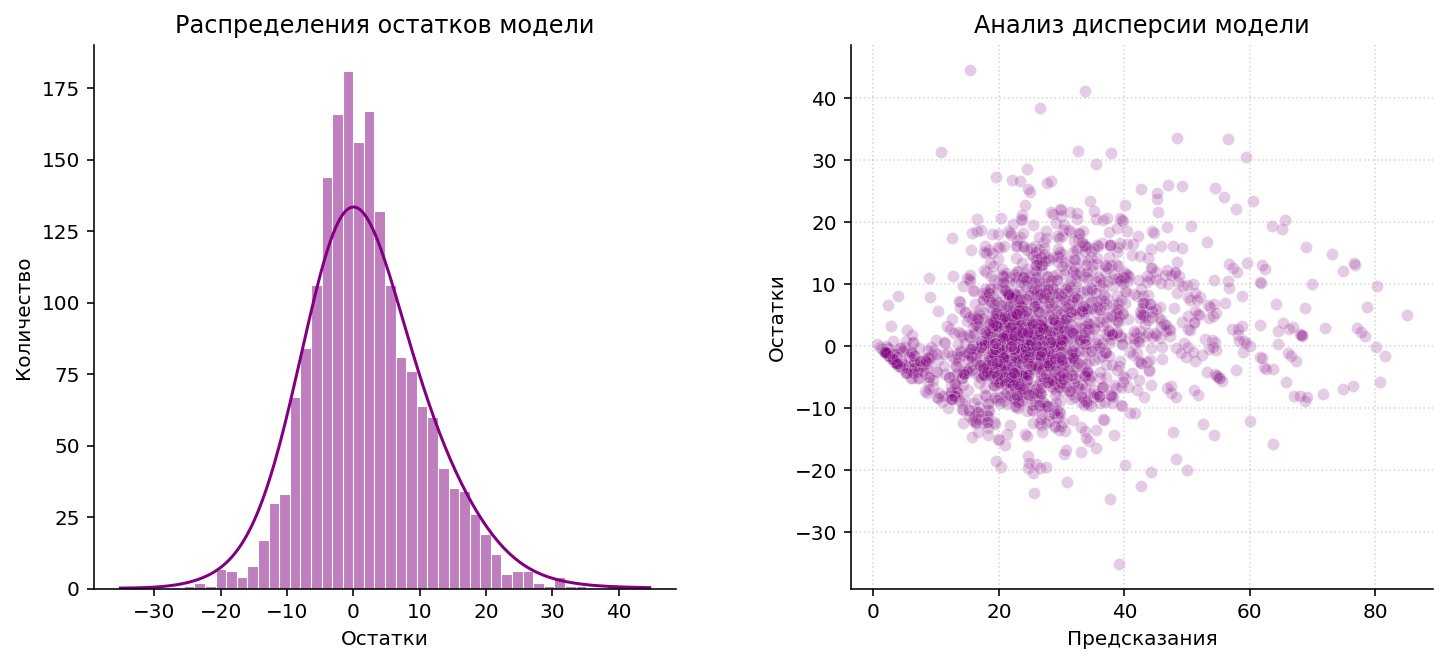

In [24]:
residuals = test_datagen_flow.labels - predict_test

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

sns.histplot(x=residuals, ax=ax1, kde=True, kde_kws={'bw_method': 0.6}, 
             color='purple', edgecolor='white')
ax1.set_title(f'Распределения остатков модели')
ax1.set_xlabel('Остатки')
ax1.set_ylabel('Количество')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

sns.scatterplot(x=predict_test, y=residuals, ax=ax2, color='purple', alpha=0.2)
ax2.set_title(f'Анализ дисперсии модели')
ax2.set_xlabel('Предсказания')
ax2.set_ylabel('Остатки')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(alpha=0.5, linestyle=':')

plt.show()

Обе модели (на основе ResNet50 и на основе InceptionResNetV2) показывают схожие результаты, однако ResNet50 значетльно быстрее обучается за счет меньшего количества параметров в свёрточной сети.

## Выводы

В ходе исследования обработан и проанализирован набор фотографий людей с указанием возраста. Построена модель, которая по фотографии определит приблизительный возраст человека.

В результате **предобработки данных** пропусков и дубликатов не обнаружено. В ходе **анализ данных** обнаружено, что в наборе содержатся фотографии людей в возрасте от 1 до 100 лет, половина людей находится в диапазоне от 20 до 41 года. Некоторые фоторграфии слегка повернуты, но в основном лица расположены вертикально. Есть фото с обрезнанными или частично закрытыми лицами, присутствуют фотографии людей в головных уборах. При этом стоит ометить, что носы в основном отцентрированы.


**Анализ данных** позволил обнаружить цикличность (суточную и недельную) в заказах такси, а также тренд на увеличение количества заказов.

**Построена и обучена модель**, которая по фотографии определит приблизительный возраст человека. Модель построена на базе свёрточной сети ResNet50, предобученной на датасете ImageNet. В результате обучения за 10 эпох модель достигла метрики качества ***MAE*=6.35** лет на тестовой выборке (то есть модель удовлетворяет требования заказчика).

Поскольку модель в среднем ошибается на 6.35 лет, её невозможно использовать для точного определения возраста человека. Однако **модель можно использовать для определения категории покупателей** сетевого супермаркета «Хлеб-Соль» («дети», «подростки», «молодые люди» и так далее). Определение возрастной категории покупателя позволит:
- предлагать товары, которые могут заинтересовать покупателя этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя (проверка документов у покупателей из категорий «молодые люди», «подростки»).

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы